In [1]:
import pandas as pd
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz
# !pip install pyLDAvis

In [2]:
df = pd.read_csv('./Dataset/train_dataset_allnouns.csv')
df.head()

,recipe_id,category,name,description,combined,cat_code,topic_list,tokenized,all_nouns
0,9014,vegetables,cheesy potato skillet stuff,this recipe came about when a friend of mine r...,cheesy potato skillet stuff came friend mine r...,9,"[3, 13, 42]","['cheesy', 'potato', 'skillet', 'stuff', 'came...","['stuff', 'friend', 'mine', 'pantry', 'hand']"
1,9492,meat,chicken honey glazed,serve with a green salad and a your favorite r...,chicken honey glazed serve green salad favorit...,4,"[-1, 1, 3, 4, 8, 9, 27, 29, 32, 33, 39, 40, 44...","['chicken', 'honey', 'glazed', 'serve', 'green...",['rice']
2,2731,meat,jaegerschnitzel,(breaded veal cutlet with mushroom sauce),jaegerschnitzel breaded veal cutlet mushroom s...,4,"[-1, 5, 8, 15, 20, 22, 39, 48, 49, 51, 54]","['jaegerschnitzel', 'breaded', 'veal', 'cutlet...","['cutlet', 'mushroom', 'sauce']"
3,10104,pasta,broccoli pork,"this is my favorite marinade for pork, orienta...",broccoli pork favorite marinade pork oriental ...,5,"[1, 17, 31, 35, 42, 45, 47, 49]","['broccoli', 'pork', 'favorite', 'marinade', '...","['pork', 'marinade', 'pork', 'hint', 'lemon', ..."
4,5478,meat,easy garlic chicken,"a quick, easy chicken recipe for days when you...",easy garlic chicken quick easy chicken days do...,4,"[-1, 1, 3, 5, 8, 9, 13, 14, 16, 17, 18, 19, 20...","['easy', 'garlic', 'chicken', 'quick', 'easy',...","['chicken', 'chicken', 'day', 'time', 'kitchen..."


In [3]:
# Extracting relevant columns 
des_name = df[['recipe_id', 'name', 'description', 'all_nouns']]

In [4]:
des_name

,recipe_id,name,description,all_nouns
0,9014,cheesy potato skillet stuff,this recipe came about when a friend of mine r...,"['stuff', 'friend', 'mine', 'pantry', 'hand']"
1,9492,chicken honey glazed,serve with a green salad and a your favorite r...,['rice']
2,2731,jaegerschnitzel,(breaded veal cutlet with mushroom sauce),"['cutlet', 'mushroom', 'sauce']"
3,10104,broccoli pork,"this is my favorite marinade for pork, orienta...","['pork', 'marinade', 'pork', 'hint', 'lemon', ..."
4,5478,easy garlic chicken,"a quick, easy chicken recipe for days when you...","['chicken', 'chicken', 'day', 'time', 'kitchen..."
...,...,...,...,...
64830,375184,30 second nut milk raw food,this gem of a recipe was found in the 2005 coo...,"['milk', 'gem', 'world', 'note', 'internet', '..."
64831,196186,roasted garlic chicken breasts,this is a quick & easy recipe that is full of ...,"['chicken', 'breast', 'flavor', 'rice', 'frien..."
64832,379150,cajun chicken salad for two,it speaks for itself.,[]
64833,313101,asian beef salad,"this is a delicious, low-calorie salad adapted...",['website']


In [5]:
# change text to list
def str_to_list(text):
    text = text[1:len(text)-1]
    text_list = text.split(',')
    text_list = [text.strip()[1:-1] for text in text_list]
    return text_list

In [7]:
des_name['all_nouns'] = des_name['all_nouns'].apply(lambda x: str_to_list(x))
des_name

,recipe_id,name,description,all_nouns
0,9014,cheesy potato skillet stuff,this recipe came about when a friend of mine r...,"[stuff, friend, mine, pantry, hand]"
1,9492,chicken honey glazed,serve with a green salad and a your favorite r...,[rice]
2,2731,jaegerschnitzel,(breaded veal cutlet with mushroom sauce),"[cutlet, mushroom, sauce]"
3,10104,broccoli pork,"this is my favorite marinade for pork, orienta...","[pork, marinade, pork, hint, lemon, fat]"
4,5478,easy garlic chicken,"a quick, easy chicken recipe for days when you...","[chicken, chicken, day, time, kitchen, people,..."
...,...,...,...,...
64830,375184,30 second nut milk raw food,this gem of a recipe was found in the 2005 coo...,"[milk, gem, world, note, internet, temperature..."
64831,196186,roasted garlic chicken breasts,this is a quick & easy recipe that is full of ...,"[chicken, breast, flavor, rice, friend, year, ..."
64832,379150,cajun chicken salad for two,it speaks for itself.,[]
64833,313101,asian beef salad,"this is a delicious, low-calorie salad adapted...",[website]


# Topic Modeling for Description and Name

## Create Corpus 

In [9]:
data_lemmatized = des_name['all_nouns'].tolist()
print(data_lemmatized[:10])

[['stuff', 'friend', 'mine', 'pantry', 'hand'], ['rice'], ['cutlet', 'mushroom', 'sauce'], ['pork', 'marinade', 'pork', 'hint', 'lemon', 'fat'], ['chicken', 'chicken', 'day', 'time', 'kitchen', 'people', 'potato', 'sugar', 'herb', 'comment', 'temperature', 'cook', 'chicken', 'instruction', 'aluminum', 'foil', 'cleanup'], ['layer', 'husband'], ['salad', 'dressing', 'mother', 'variation', 'artichoke'], ['pork', 'scallop', 'lemon', 'herb', 'try', 'chicken'], ['casserole', 'prepare', 'grandmother', 'vegetable'], ['mushroom', 'roll', 'mushroom', 'slice', 'flavour']]


In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [11]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'friend'), (1, 'hand'), (2, 'mine'), (3, 'pantry'), (4, 'stuff'), (5, 'rice'), (6, 'cutlet'), (7, 'mushroom'), (8, 'sauce'), (9, 'fat'), (10, 'hint'), (11, 'lemon'), (12, 'marinade'), (13, 'pork'), (14, 'aluminum'), (15, 'chicken'), (16, 'cleanup'), (17, 'comment'), (18, 'cook'), (19, 'day'), (20, 'foil'), (21, 'herb'), (22, 'instruction'), (23, 'kitchen'), (24, 'people'), (25, 'potato'), (26, 'sugar'), (27, 'temperature'), (28, 'time'), (29, 'husband'), (30, 'layer'), (31, 'artichoke'), (32, 'dressing'), (33, 'mother'), (34, 'salad'), (35, 'variation'), (36, 'scallop'), (37, 'try'), (38, 'casserole'), (39, 'grandmother'), (40, 'prepare'), (41, 'vegetable'), (42, 'flavour'), (43, 'roll'), (44, 'slice'), (45, ''), (46, 'egg'), (47, 'one'), (48, 'bar'), (49, 'tooth')]

Total Vocabulary Size: 6907


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [24]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [25]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.29287444578248345
Perplexity Score:  -6.661649904092894

topic number:  3
Coherence Score:  0.42106093962707
Perplexity Score:  -6.687420136969794

topic number:  4
Coherence Score:  0.43164742003150686
Perplexity Score:  -6.7343772536510444

topic number:  5
Coherence Score:  0.4524051125145891
Perplexity Score:  -6.771986668739029

topic number:  6
Coherence Score:  0.42237550364590587
Perplexity Score:  -6.816601062751111

topic number:  7
Coherence Score:  0.4146431907764815
Perplexity Score:  -6.838672108900506

topic number:  8
Coherence Score:  0.42724001822637536
Perplexity Score:  -6.86597737689151

topic number:  9
Coherence Score:  0.44306311424733663
Perplexity Score:  -6.934037264322304

topic number:  10
Coherence Score:  0.43826660527755895
Perplexity Score:  -7.0364042912744065

topic number:  11
Coherence Score:  0.43221989030698293
Perplexity Score:  -7.211890697014653

topic number:  12
Coherence Score:  0.43232520958005377
Perple

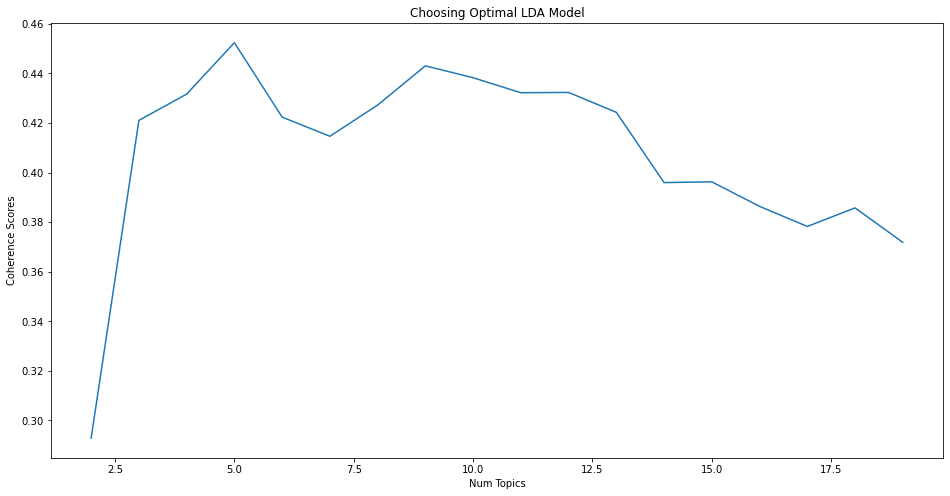

In [26]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [28]:
ntopics_des_name = 5

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [29]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.053*"sauce" + 0.041*"soup" + 0.032*"chicken" + 0.029*"pork" + '
  '0.024*"rice" + 0.021*"pot" + 0.021*"beef" + 0.017*"pasta" + 0.016*"corn" + '
  '0.015*"meat"'),
 (1,
  '0.129*"time" + 0.054*"bread" + 0.029*"cooking" + 0.020*"magazine" + '
  '0.016*"prep" + 0.013*"hour" + 0.013*"cook" + 0.012*"oil" + 0.011*"roll" + '
  '0.011*"minute"'),
 (2,
  '0.063*"salad" + 0.049*"potato" + 0.043*"chicken" + 0.024*"cheese" + '
  '0.020*"side" + 0.019*"bean" + 0.018*"way" + 0.017*"flavor" + 0.015*"use" + '
  '0.014*"egg"'),
 (3,
  '0.036*"chocolate" + 0.031*"cookie" + 0.027*"cream" + 0.025*"cake" + '
  '0.024*"pie" + 0.019*"sugar" + 0.016*"butter" + 0.016*"coffee" + '
  '0.015*"dessert" + 0.014*""'),
 (4,
  '0.041*"family" + 0.035*"year" + 0.025*"kid" + 0.024*"friend" + '
  '0.020*"recipe" + 0.019*"mom" + 0.015*"drink" + 0.014*"hope" + 0.012*"party" '
  '+ 0.012*"breakfast"')]


In [30]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [31]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(des_name)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [32]:
des_name['Topic'] = topic_num

In [33]:
des_name

,recipe_id,name,description,all_nouns,Topic
0,9014,cheesy potato skillet stuff,this recipe came about when a friend of mine r...,"[stuff, friend, mine, pantry, hand]","[1, 4, 2, 0, 3]"
1,9492,chicken honey glazed,serve with a green salad and a your favorite r...,[rice],"[0, 1, 2, 3, 4]"
2,2731,jaegerschnitzel,(breaded veal cutlet with mushroom sauce),"[cutlet, mushroom, sauce]","[0, 2, 4, 1, 3]"
3,10104,broccoli pork,"this is my favorite marinade for pork, orienta...","[pork, marinade, pork, hint, lemon, fat]","[2, 0, 3, 1, 4]"
4,5478,easy garlic chicken,"a quick, easy chicken recipe for days when you...","[chicken, chicken, day, time, kitchen, people,...","[2, 1, 3, 0, 4]"
...,...,...,...,...,...
64830,375184,30 second nut milk raw food,this gem of a recipe was found in the 2005 coo...,"[milk, gem, world, note, internet, temperature...","[2, 3, 1, 0, 4]"
64831,196186,roasted garlic chicken breasts,this is a quick & easy recipe that is full of ...,"[chicken, breast, flavor, rice, friend, year, ...","[0, 4, 2, 3, 1]"
64832,379150,cajun chicken salad for two,it speaks for itself.,[],"[3, 1, 4, 0, 2]"
64833,313101,asian beef salad,"this is a delicious, low-calorie salad adapted...",[website],"[4, 1, 0, 2, 3]"


In [34]:
des_name_final = des_name[['recipe_id', 'name', 'description', 'Topic']]
des_name_final.head()

,recipe_id,name,description,Topic
0,9014,cheesy potato skillet stuff,this recipe came about when a friend of mine r...,"[1, 4, 2, 0, 3]"
1,9492,chicken honey glazed,serve with a green salad and a your favorite r...,"[0, 1, 2, 3, 4]"
2,2731,jaegerschnitzel,(breaded veal cutlet with mushroom sauce),"[0, 2, 4, 1, 3]"
3,10104,broccoli pork,"this is my favorite marinade for pork, orienta...","[2, 0, 3, 1, 4]"
4,5478,easy garlic chicken,"a quick, easy chicken recipe for days when you...","[2, 1, 3, 0, 4]"


In [35]:
des_name_final.to_csv('./Dataset/description_name_features_final_all_noun.csv', index=False) 

### Model Evaluation

In [36]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -6.773625873054448
Coherence Score:  0.44222736820312447


## Visualisation

In [37]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.159688  0.196595       1        1  21.382552
2      0.077544 -0.204708       2        1  21.168002
0      0.091551 -0.199918       3        1  20.945375
1      0.036471  0.196071       4        1  20.147319
4     -0.365254  0.011960       5        1  16.356752, topic_info=           Term          Freq         Total Category  logprob  loglift
28         time  12779.000000  12779.000000  Default  30.0000  30.0000
34        salad   6528.000000   6528.000000  Default  29.0000  29.0000
8         sauce   5435.000000   5435.000000  Default  28.0000  28.0000
131       bread   5284.000000   5284.000000  Default  27.0000  27.0000
25       potato   5092.000000   5092.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
99       summer    603.843243   1911.417505   Topic5  -4.8881   0.6582
420    magazine    638.755050   2655.713880   Topic5  -4.8319   0.3856
111       enjoy    535.253682   1349.500597   Topic5  -5.0087   0.8858
245     version    554.338200   1871.010545   Topic5  -4.9737   0.5941
333  ingredient    537.348612   3818.430663   Topic5  -5.0048  -0.1504

[259 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
45        1  0.999615          
1171      5  0.998266     adult
144       1  0.197110    amount
144       2  0.217296    amount
144       3  0.409063    amount
...     ...       ...       ...
107       1  0.037230      year
107       3  0.000295      year
107       4  0.140056      year
107       5  0.822312      year
1208      2  0.997672  zucchini

[307 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2, 5])

## Word Count of Topic Keywords

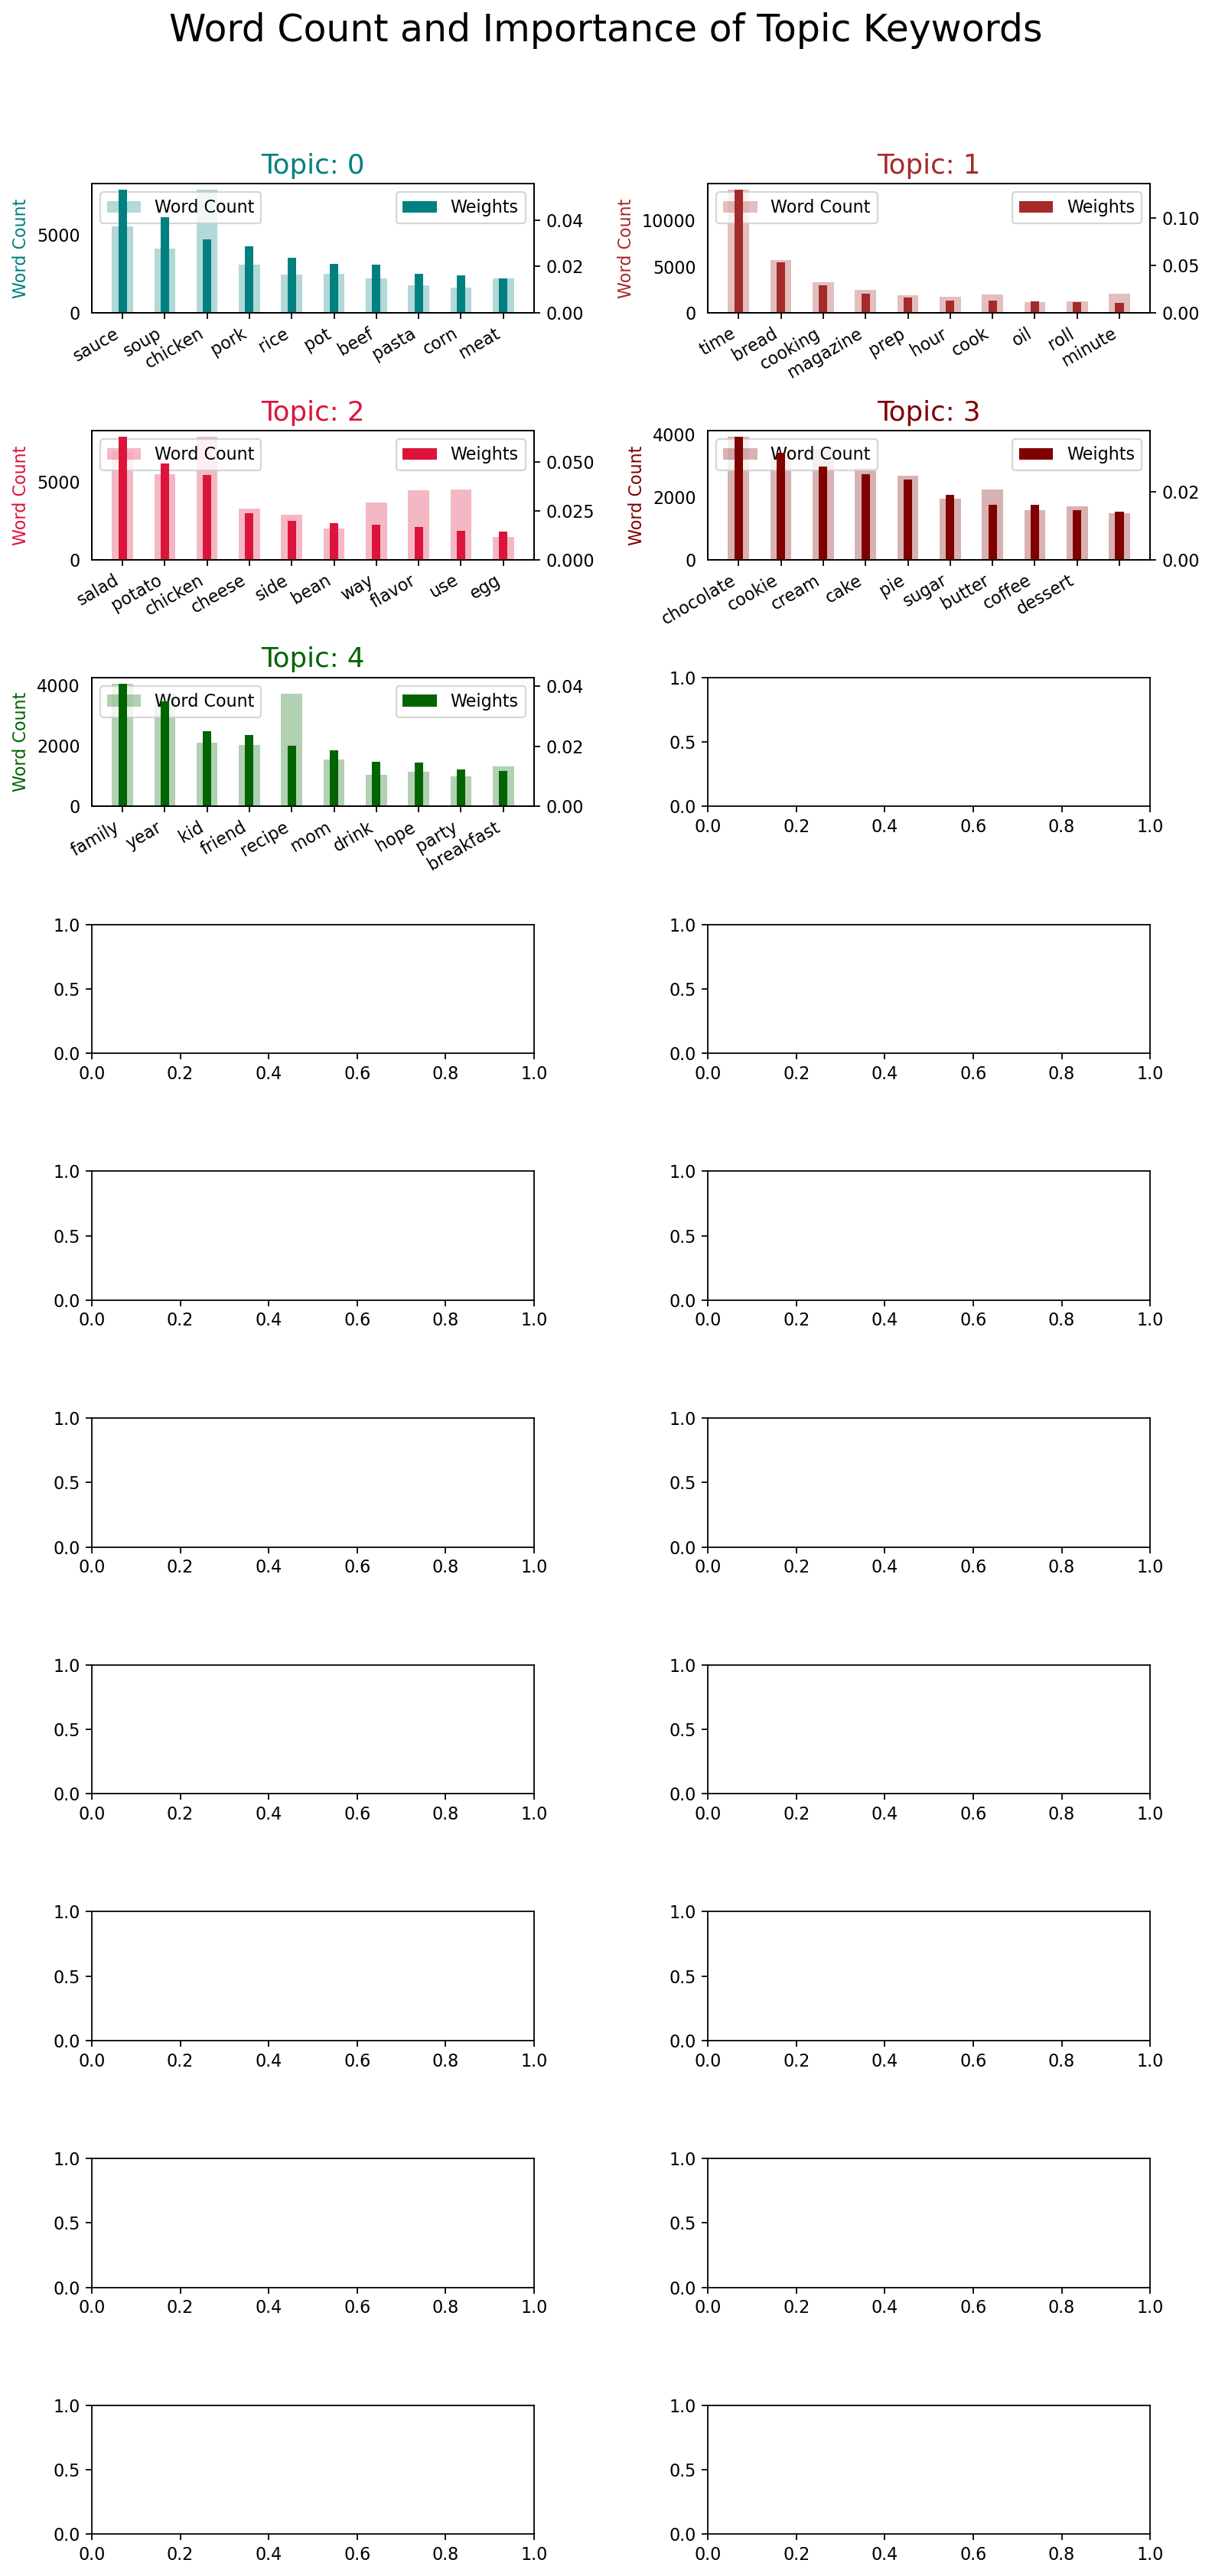

In [38]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(10, 2, figsize=(10,20), dpi=160)
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()